### 데이터 준비 - twitter

In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from smac import HyperparameterOptimizationFacade, Scenario
from ConfigSpace import Configuration, ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter

In [75]:
### RANDOM WORKLOAD AND SAMPLE
import random
import glob
import os
import sys
import pandas as pd


knob_list = glob.glob("/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_*.cnf")
metrics = pd.read_csv("/home/sein/2023_EDBT/KCC_twitter_dataset/external_metrics/external_results.csv")

# df_1 = df.drop([0, 3], axis = 0)

metrics = metrics.drop(['Unnamed: 0'], axis = 1)
# metrics = pd.DataFrame(metrics)


In [76]:
# drop_df = metrics.drop(metrics.index[100:131], inplace=True)
# labels=range(40, 45), axis=0

In [77]:
###전체 샘플에 대한 config num = 200

conf_best_cluster = []
cnt = 0

for xx in range(len(knob_list)):
    path = "/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_{}.cnf".format(xx)
    # knob_list = glob.glob("/home/sein/2023_EDBT/KCC_tpcc_dataset/my_*.cnf")
    a_all = pd.read_csv(path, sep="=", names=['Sample', 'value'], header=2)
    a_all = a_all.set_index("Sample")
    cur_all_df = a_all.T
    
    if cnt == 0:
        concat_all_df = cur_all_df
    else :
        concat_all_df = pd.concat([concat_all_df, cur_all_df], axis=0)
    cnt += 1
concat_all_df = concat_all_df.reset_index()
concat_all_df = concat_all_df.drop(["index"],axis=1)
concat_all_df = concat_all_df.drop(concat_all_df.columns[[0,1]], axis=1)


concat_all_df

Sample,automatic_sp_privileges,back_log,binlog_cache_size,binlog_group_commit_sync_delay,binlog_group_commit_sync_no_delay_count,binlog_rows_query_log_events,binlog_stmt_cache_size,bulk_insert_buffer_size,default_week_format,div_precision_increment,...,stored_program_cache,sync_binlog,table_definition_cache,table_open_cache,table_open_cache_instances,thread_cache_size,tmp_table_size,transaction_alloc_block_size,transaction_prealloc_size,updatable_views_with_limit
0,0,37596,52628590,865990,856318,1,44160666,18380630,4,19,...,277466,706150,340396,500266,38,6204,28678,75343,37285,0
1,1,4945,15395448,412811,823497,0,18944539,17027058,4,27,...,352929,82743,275069,86476,62,11432,15791584,56617,34320,0
2,0,7931,59813952,341095,777123,0,17726392,65906625,2,25,...,241624,595940,386662,142708,41,10048,43343089,79768,33757,0
3,1,13373,60853394,674639,39463,0,26002941,28599726,6,20,...,96888,382249,353552,517077,36,8702,52067907,65251,14319,0
4,1,20819,19850945,603712,740042,1,39419136,22658544,1,6,...,71794,210134,158503,211002,25,4713,3278957,37032,50990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,59310,28430506,421775,826242,1,1352566,60361339,6,12,...,307047,504687,10111,61073,12,542,2237474,84409,58193,0
196,1,38460,23619454,60256,395272,1,53004944,3740357,5,23,...,500576,197555,114593,150572,18,4169,31980894,5171,80027,1
197,0,24559,23048363,473402,225779,0,64429539,59930358,0,23,...,119159,557676,150172,511835,54,5971,56527511,64639,35982,1
198,0,30682,45247502,264510,806376,0,20579351,51007971,6,24,...,198502,312087,189265,13012,52,8392,48990947,65970,46180,1


### 전체 데이터 (#200 / 139개 knob)에 대한 실험

In [173]:
###XGBRegressor 전체 데이터에 대해서

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



### 전체 config에서 성능이 좋은 config 10개 고르기

In [157]:
### TPS / LATENCY TOP 10

metrics['score'] = metrics['tps'] / metrics['latency']

metric_list_sorting = metrics.sort_values('score', ascending=False)

best_config_perform = metric_list_sorting.head(10)
best_config_perform
# random_metric_list.head(10)

,tps,latency,score
139,7830.031983,550,14.236422
155,7920.117213,558,14.193758
126,7869.536194,555,14.179344
83,7349.121651,582,12.627357
74,7334.782788,590,12.431835
69,7380.264804,594,12.424688
180,7243.303547,583,12.424191
79,6994.513899,580,12.059507
87,7078.647713,597,11.857031
186,7019.134642,594,11.816725


In [158]:
### 성능 좋은 10개 config

best_config_perform_idx = best_config_perform.index
best_config = []
for j in range(len(best_config_perform_idx)):
    n_knobs = pd.read_table("/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_{}.cnf".format(best_config_perform_idx[j]))
    best_config.append(n_knobs)

In [159]:
### best config 10개에 대한 dataframe (knob은 그대로)
cnt = 0

best_config_perform_idx = best_config_perform.index
best_config = []
for j in range(len(best_config_perform_idx)):
    path = "/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_{}.cnf".format(best_config_perform_idx[j])
    best_all = pd.read_csv(path, sep="=", names=['Sample', 'value'], header=2)
    best_all = best_all.set_index("Sample")
    cur_best_all = best_all.T
    
    if cnt == 0:
        best_all_df = cur_best_all
    else :
        best_all_df = pd.concat([best_all_df, cur_best_all], axis=0)
    cnt += 1
best_all_df = best_all_df.reset_index()
best_all_df = best_all_df.drop(["index"],axis=1)
best_all_df_ = best_all_df.drop([best_all_df.columns[0],best_all_df.columns[1]], axis=1)
best_all_df = best_all_df_
best_all_df

    

Sample,automatic_sp_privileges,back_log,binlog_cache_size,binlog_group_commit_sync_delay,binlog_group_commit_sync_no_delay_count,binlog_rows_query_log_events,binlog_stmt_cache_size,bulk_insert_buffer_size,default_week_format,div_precision_increment,...,stored_program_cache,sync_binlog,table_definition_cache,table_open_cache,table_open_cache_instances,thread_cache_size,tmp_table_size,transaction_alloc_block_size,transaction_prealloc_size,updatable_views_with_limit
0,1,62584,1539674,944250,574381,1,42675089,50346344,1,4,...,19307,28322,389690,3833,37,4866,54791711,16357,42179,0
1,0,20536,54268864,752489,293510,1,12912030,1329242,1,18,...,395056,823919,267770,238706,14,7156,45254736,126865,30678,0
2,1,48155,21453014,710466,303082,1,3129367,60855972,5,1,...,261099,874783,371028,514859,28,12998,12928821,2472,110140,0
3,1,8399,16055083,801204,372413,1,65373762,26834525,5,6,...,305561,942410,381022,199418,40,12687,64654885,18913,37823,0
4,0,41517,27839073,861937,611627,0,6315291,13395500,3,4,...,285969,416164,487970,101800,6,16369,65044618,94296,121409,1
5,0,35736,15643420,28279,609176,1,7233457,14624045,3,27,...,383043,957444,179646,215135,35,3571,47041272,79333,113716,0
6,1,36190,41421349,86330,764442,0,63778503,55252697,4,14,...,22273,78289,343419,76500,62,14963,27219447,76381,129981,1
7,0,15651,23490671,963633,728258,0,43816068,2172605,4,17,...,143184,114960,10952,264475,47,9643,35860780,48277,21725,0
8,1,58606,31582820,437396,2200,1,5770018,48330654,5,15,...,486023,579353,296695,419276,2,14804,66018124,119323,70036,0
9,0,49017,8355220,718308,246433,1,20460742,14964729,7,15,...,221646,948414,31487,385363,23,3702,10336281,87049,20588,0


In [ ]:
###XGBRegressor 전체 데이터에 대해서

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



### 수정

In [160]:
###XGBRegressor top 10 config 데이터에 대해서

### X_top // top 10 config
### Y_top // top 10 performance

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_top = np.array(best_all_df)
Y_top = np.array(best_config_perform[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_top)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_top)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



In [161]:
best_config_perform

,tps,latency,score
139,7830.031983,550,14.236422
155,7920.117213,558,14.193758
126,7869.536194,555,14.179344
83,7349.121651,582,12.627357
74,7334.782788,590,12.431835
69,7380.264804,594,12.424688
180,7243.303547,583,12.424191
79,6994.513899,580,12.059507
87,7078.647713,597,11.857031
186,7019.134642,594,11.816725


In [172]:
best_all_df.columns[0]

'basedir '

### Top-K knob 구하기 by SHAP VALUE

In [149]:
#####Shap_value

###XGBRegressor

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit(X_train)
Y_scaler = MinMaxScaler().fit(y_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)
scaled_y_train = Y_scaler.transform(y_train)
scaled_y_test = Y_scaler.transform(y_test)

# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)

estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model_pred = MultiOutputRegressor(estimator = estimator).fit(scaled_X_train, y_train)


pred = my_model_pred.predict(scaled_X_test)

#rmse
print('RMSE : ',mean_squared_error(y_test, pred, squared=False))
print('R2_SCORE : ', r2_score(y_test, pred))
# print('PCC : ', precision_score(y_test, pred, average='weighted'))

# rmse r2 pcc




RMSE :  1639843.7031751447
R2_SCORE :  0.4966707661310153


In [ ]:
import shap

explainer = shap.KernelExplainer(my_model_pred.predict,scaled_X_test)
shap_values = explainer.shap_values(scaled_X_test)

# shap.summary_plot(shap_values,scaled_X_test,feature_names=shap_x.columns)

from sklearn.linear_model import LassoLarsIC
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
model = LassoLarsIC(normalize=False)


In [31]:
shap_x = pd.DataFrame(scaled_X_test) #X_test Dataframe 화
list_int = list(concat_all_df.columns)
list_str = list(map(str, list_int))
shap_x.columns = list_str #add index

# concat_all_df.columns

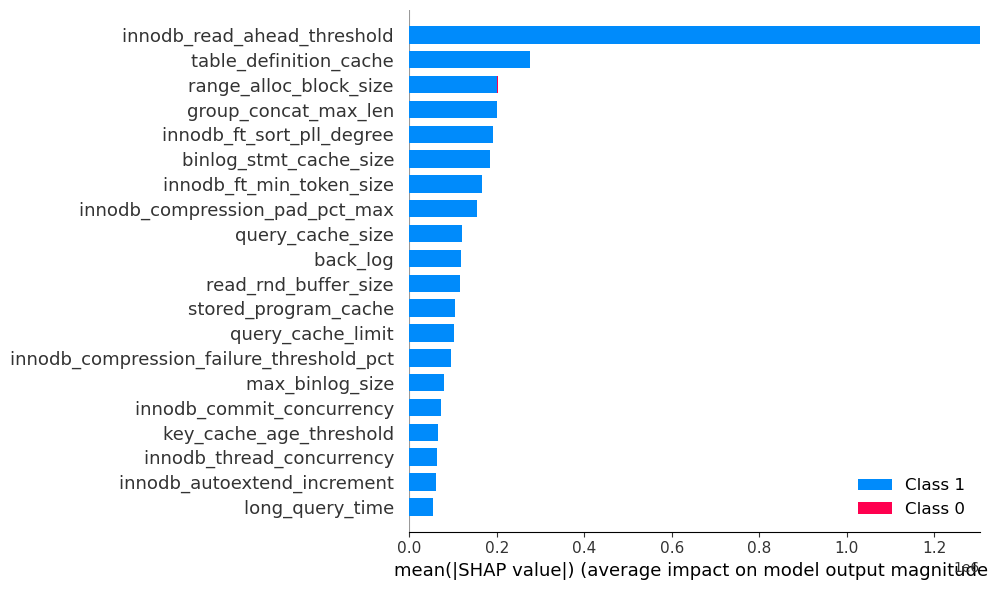

In [32]:
# shap.summary_plot(shap_values,scaled_X_test, plot_type='bar', feature_names=shap_x.columns)
import plotly.graph_objs as go

fig = shap.summary_plot(shap_values, scaled_X_test, plot_type="bar" , feature_names=shap_x.columns, plot_size=[10,6] )


In [33]:
# shap_values.sort(reverse=True)
tps_shap_values = pd.DataFrame(shap_values[0])
latency_shap_values = pd.DataFrame(shap_values[1])

tps_shap_values.columns = shap_x.columns
latency_shap_values.columns = shap_x.columns
# latency_shap_values

In [34]:
### tps 순서대로 config 출력

#### About Throuthput

# 데이터프레임을 넘파이로
shap_tps_np = np.array(tps_shap_values)

# array의 값을 절댓값으로 반환
shap_tps_np = np.abs(shap_tps_np)

# axis=0 기준으로 평균값 계산
shap_tps_mean = np.mean(shap_tps_np, 0)

# sorting index 반환
sorted_index_tps = shap_tps_mean.argsort()[::-1]

tps_index = []
for ind in sorted_index_tps:
    print(tps_shap_values.columns[ind])
    tps_index.append(tps_shap_values.columns[ind])

range_alloc_block_size 
innodb_random_read_ahead 
binlog_group_commit_sync_no_delay_count 
innodb_concurrency_tickets 
max_prepared_stmt_count 
bulk_insert_buffer_size 
innodb_commit_concurrency 
query_alloc_block_size 
innodb_open_files 
innodb_max_purge_lag_delay 
back_log 
innodb_adaptive_hash_index_parts 
innodb_stats_transient_sample_pages 
flush_time 
default_week_format 
max_heap_table_size 
binlog_stmt_cache_size 
join_buffer_size 
innodb_read_ahead_threshold 
innodb_ft_total_cache_size 
binlog_group_commit_sync_delay 
expire_logs_days 
innodb_change_buffer_max_size 
innodb_ft_result_cache_limit 
ft_query_expansion_limit 
transaction_alloc_block_size 
innodb_compression_level 
table_open_cache 
innodb_online_alter_log_max_size 
innodb_buffer_pool_size 
key_cache_division_limit 
read_buffer_size 
innodb_sync_spin_loops 
innodb_autoextend_increment 
key_buffer_size 
innodb_log_buffer_size 
innodb_read_io_threads 
innodb_file_per_table 
key_cache_age_threshold 
binlog_cache_size 


In [35]:
#### About Latency

# 데이터프레임을 넘파이로
shap_la_np = np.array(latency_shap_values)

# array의 값을 절댓값으로 반환
shap_la_np = np.abs(shap_la_np)

# axis=0 기준으로 평균값 계산
shap_la_mean = np.mean(shap_la_np, 0)

# sorting index 반환
sorted_index_la = shap_la_mean.argsort()[::-1]

latency_index = []
for ind in sorted_index_la:
    print(latency_shap_values.columns[ind])
    latency_index.append(latency_shap_values.columns[ind])

innodb_read_ahead_threshold 
table_definition_cache 
group_concat_max_len 
range_alloc_block_size 
innodb_ft_sort_pll_degree 
binlog_stmt_cache_size 
innodb_ft_min_token_size 
innodb_compression_pad_pct_max 
query_cache_size 
back_log 
read_rnd_buffer_size 
stored_program_cache 
query_cache_limit 
innodb_compression_failure_threshold_pct 
max_binlog_size 
innodb_commit_concurrency 
key_cache_age_threshold 
innodb_thread_concurrency 
innodb_autoextend_increment 
long_query_time 
max_binlog_cache_size 
innodb_sort_buffer_size 
max_heap_table_size 
innodb_purge_rseg_truncate_frequency 
query_alloc_block_size 
innodb_max_dirty_pages_pct_lwm 
innodb_purge_threads 
innodb_log_buffer_size 
innodb_ft_num_word_optimize 
binlog_cache_size 
transaction_prealloc_size 
binlog_rows_query_log_events 
read_buffer_size 
key_cache_block_size 
innodb_spin_wait_delay 
sort_buffer_size 
eq_range_index_dive_limit 
max_seeks_for_key 
innodb_log_file_size 
binlog_group_commit_sync_no_delay_count 
sync_binlog 

In [92]:
len(latency_index)

139

In [ ]:
all_knob_list = list(concat_all_df.columns)
all_knob_list

In [98]:
concat_all_df

Sample,automatic_sp_privileges,back_log,binlog_cache_size,binlog_group_commit_sync_delay,binlog_group_commit_sync_no_delay_count,binlog_rows_query_log_events,binlog_stmt_cache_size,bulk_insert_buffer_size,default_week_format,div_precision_increment,...,stored_program_cache,sync_binlog,table_definition_cache,table_open_cache,table_open_cache_instances,thread_cache_size,tmp_table_size,transaction_alloc_block_size,transaction_prealloc_size,updatable_views_with_limit
0,0,37596,52628590,865990,856318,1,44160666,18380630,4,19,...,277466,706150,340396,500266,38,6204,28678,75343,37285,0
1,1,4945,15395448,412811,823497,0,18944539,17027058,4,27,...,352929,82743,275069,86476,62,11432,15791584,56617,34320,0
2,0,7931,59813952,341095,777123,0,17726392,65906625,2,25,...,241624,595940,386662,142708,41,10048,43343089,79768,33757,0
3,1,13373,60853394,674639,39463,0,26002941,28599726,6,20,...,96888,382249,353552,517077,36,8702,52067907,65251,14319,0
4,1,20819,19850945,603712,740042,1,39419136,22658544,1,6,...,71794,210134,158503,211002,25,4713,3278957,37032,50990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,59310,28430506,421775,826242,1,1352566,60361339,6,12,...,307047,504687,10111,61073,12,542,2237474,84409,58193,0
196,1,38460,23619454,60256,395272,1,53004944,3740357,5,23,...,500576,197555,114593,150572,18,4169,31980894,5171,80027,1
197,0,24559,23048363,473402,225779,0,64429539,59930358,0,23,...,119159,557676,150172,511835,54,5971,56527511,64639,35982,1
198,0,30682,45247502,264510,806376,0,20579351,51007971,6,24,...,198502,312087,189265,13012,52,8392,48990947,65970,46180,1


In [39]:
import numpy as np
latency_score = dict(zip(latency_index,np.arange(len(latency_index))))
tps_score = dict(zip(tps_index,np.arange(len(tps_index))))
total_score = dict(zip(knob_list, score_list))

knob_list = []
score_list = []
for col in all_knob_list:
    score= latency_score[col]+tps_score[col]
    # print("{} KNOB SCORE : ".format(col), score)
    knob_list.append(col)
    score_list.append(score)
    
    

In [129]:
total_score.values()

dict_values([48, 44, 35, 38, 94, 158, 75, 136, 55, 68, 225, 80, 173, 238, 44, 89, 86, 171, 111, 28, 90, 116, 27, 100, 268, 137, 240, 159, 105, 103, 238, 224, 185, 127, 234, 67, 194, 181, 183, 221, 169, 149, 207, 152, 158, 104, 75, 45, 59, 141, 71, 50, 37, 40, 95, 112, 187, 50, 177, 167, 220, 201, 74, 118, 52, 24, 140, 65, 215, 32, 67, 74, 215, 178, 233, 197, 135, 200, 230, 60, 246, 47, 211, 239, 118, 128, 68, 127, 193, 184, 200, 222, 239, 190, 74, 150, 130, 113, 129, 91, 95, 67, 69, 178, 40, 239, 34, 136, 200, 165, 193, 177, 205, 226, 98, 109, 138, 134, 201, 221, 131, 59, 80, 249, 137, 212, 246, 188, 225, 49, 180, 177, 149, 168, 116, 200, 110, 109, 203])

In [ ]:
total_score

In [40]:
print(sorted(total_score.items(), key=lambda x:x[1]))
print(dict(sorted(total_score.items(), key=lambda x:x[1])))
top_rank = sorted(total_score,key=lambda x:total_score[x])

[('range_alloc_block_size ', 3), ('innodb_read_ahead_threshold ', 18), ('back_log ', 19), ('binlog_stmt_cache_size ', 21), ('innodb_commit_concurrency ', 21), ('query_alloc_block_size ', 31), ('max_heap_table_size ', 37), ('binlog_group_commit_sync_no_delay_count ', 41), ('table_definition_cache ', 46), ('group_concat_max_len ', 50), ('innodb_autoextend_increment ', 51), ('key_cache_age_threshold ', 54), ('stored_program_cache ', 55), ('flush_time ', 57), ('long_query_time ', 59), ('innodb_max_purge_lag_delay ', 61), ('read_rnd_buffer_size ', 61), ('innodb_log_buffer_size ', 62), ('binlog_group_commit_sync_delay ', 63), ('read_buffer_size ', 63), ('max_prepared_stmt_count ', 65), ('binlog_cache_size ', 68), ('innodb_change_buffer_max_size ', 71), ('bulk_insert_buffer_size ', 73), ('query_cache_size ', 74), ('expire_logs_days ', 77), ('ft_query_expansion_limit ', 78), ('innodb_sort_buffer_size ', 79), ('innodb_spin_wait_delay ', 80), ('innodb_purge_rseg_truncate_frequency ', 82), ('tabl

In [41]:
top_20_config = top_rank[:20]

In [42]:
top_10_config = top_rank[:10]

In [154]:
top_10_config

['innodb_read_ahead_threshold ',
 'innodb_buffer_pool_size ',
 'innodb_adaptive_hash_index_parts ',
 'innodb_rollback_segments ',
 'max_sort_length ',
 'binlog_cache_size ',
 'innodb_max_purge_lag ',
 'binlog_group_commit_sync_delay ',
 'innodb_max_purge_lag_delay ',
 'max_prepared_stmt_count ']

### Top-k knob에 대한 실험

In [ ]:
###XGBRegressor 전체 데이터에 대해서

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



### 수정

In [180]:
###XGBRegressor top_10_knob을 가진 config에 대해서 (config 내에 성능 좋은 knob 10개)
### Y는 어찌해야하는지? // Y도 똑같음

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

top_10_config_all= concat_all_df[top_10_config]
# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(top_10_config_all)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)

###top_10_config

### Top Config 내에 Top-k knob에 대한 실험

In [ ]:
###XGBRegressor 전체 데이터에 대해서

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



### 수정

In [192]:
###XGBRegressor top_10_knob을 가진 config에 대해서 (config 내에 성능 좋은 knob 10개)
###config Top-10개 내에 Top-10개 knob

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

top_10_config_all= concat_all_df[top_10_config]
top_10_config_with_top_knob = best_all_df[top_10_config]
# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(top_10_config_with_top_knob)
Y_all = np.array(metrics[['tps', 'latency']])
Y_top_10 = Y_all[:10]

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_top_10)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)

###top_10_config

### 공통 / excel 파일 명 확인

In [193]:
class SMAC(object):
    def __init__(self, iteration, model, config_info_path=None):
        self.iteration = iteration
        self.my_model = model
        self.config_info_path = config_info_path
        
        self._get_config_info()
        self._get_scenario_path_name()
        self._init_configuration()
            
    
    def _get_scenario_path_name(self):
        i = 0
        date_str = datetime.today().strftime("%Y%m%d")
        name = date_str + '-' + '%02d'%i
        while os.path.isdir(os.path.join('smac3_output', name)):
            i += 1
            name = date_str + '-' + '%02d'%i
        self.scenario_name = name
        print("#########################################################")
        print("Scenario data will saved in ", os.path.join('smac3_output', self.scenario_name))
        print("#########################################################\n")
    
    def _get_config_info(self):
        if self.config_info_path is None:
            self.config_info = pd.read_csv('/home/sein/2023_EDBT/config_last_twitter_top10.csv', index_col=0)
        else:
            self.config_info = pd.read_csv(self.config_info_path, index_col=0)

      
    
    def _get_history(self):
        self.history_configs = self.smac.runhistory.get_configs()
    
    def _init_configuration(self):
        self.cs = ConfigurationSpace()
        
        ## Build Configuriation Generator
        hyps = []
        for name in self.config_info.index:
            knob = self.config_info.loc[name]
            # knob = self.config_info[name]
            
            if knob['type'] == 'boolean' or knob['type'] == 'integer':
                if knob['default'] > knob['max_64mb']:
                    ## If default is larger than max_64mb, then use median of min and max_64mb as default
                    tmp_def = (knob['min'] + knob['max_64mb'].astype(int)) // 2
                else:
                    tmp_def = knob['default']
                hyps.append(UniformIntegerHyperparameter(name=str(name), lower=int(knob['min']), upper=int(knob['max_64mb']), default_value=tmp_def.astype(int)))
            elif knob['type'] == 'float':
                hyps.append(UniformFloatHyperparameter(name=str(name), lower=knob['min'], upper=knob['max_64mb'], default_value=knob['default']))
        self.cs.add_hyperparameters(hyps)
        
        self.scenario = Scenario(self.cs, deterministic=True, n_trials=self.iteration, name=self.scenario_name)
    
    def _target_function(self, config: Configuration, seed: int = 0) -> float:
        X = pd.DataFrame(config.get_dictionary().values(), index=self.config_info.index).T
        ## scaled_X = X.values
        ## scaled_X = Scaler.transform(X)
        ## res = regression_model(scaled_X)
        pred = self.my_model.predict(X)
        for ii in range(len(pred)):
            res = pred[ii][1] / pred[ii][0]
        return res # a smaller result means better
    
    
    def tune(self):
        '''
            After smac.optimize(), the history data are saved in output_dir: 'smac3_output'
        '''
        self.smac = HyperparameterOptimizationFacade(scenario=self.scenario, target_function=self._target_function)
        self.incumbent = self.smac.optimize() #minimize
    
    def plot_history(self):
        self._get_history()
        
#         res = []
        self.his_inc = []
        inc = np.inf
        ## Get minimum results on each iteration
        for his_cfg in self.history_configs:
            his_res = self.smac.validate(his_cfg)
            if his_res < inc:
                inc = his_res
            self.his_inc.append(inc)
#             res.append(his_res)

        plt.plot(self.his_inc)
        plt.xlabel('Iteration')
        plt.ylabel('result')
        plt.show()

In [199]:
tuner = SMAC(iteration=200, model=my_model)
tuner.tune()

#########################################################
Scenario data will saved in  smac3_output/20230427-38
#########################################################

[INFO][abstract_initial_design.py:82] Reducing the number of initial configurations from 100 to 50 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:134] Using 50 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:513] Added config 0fa2b2 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:298] Finished 50 trials.
[INFO][smbo.py:298] Finished 100 trials.
[INFO][smbo.py:298] Finished 150 trials.
[INFO][smbo.py:298] Finished 200 trials.
[INFO][smbo.py:306] Configuration budget is exhausted:
[INFO][smbo.py:307] --- Remaining wallclock time: inf
[INFO][smbo.py:308] --- Remaining cpu time: inf
[INFO][smbo.py:309] --- Remaining trials: 0


In [200]:
new_config = tuner.smac.runhistory.get_configs()
new_config

[Configuration(values={
   'binlog_cache_size': 17912917,
   'binlog_group_commit_sync_delay': 620565,
   'innodb_adaptive_hash_index_parts': 56,
   'innodb_buffer_pool_size': 2263730125,
   'innodb_max_purge_lag': 57803538,
   'innodb_max_purge_lag_delay': 4955157,
   'innodb_read_ahead_threshold': 62,
   'innodb_rollback_segments': 128,
   'max_prepared_stmt_count': 809643,
   'max_sort_length': 5984351,
 }),
 Configuration(values={
   'binlog_cache_size': 51086627,
   'binlog_group_commit_sync_delay': 268056,
   'innodb_adaptive_hash_index_parts': 481,
   'innodb_buffer_pool_size': 4186837351,
   'innodb_max_purge_lag': 21466860,
   'innodb_max_purge_lag_delay': 5537616,
   'innodb_read_ahead_threshold': 11,
   'innodb_rollback_segments': 20,
   'max_prepared_stmt_count': 444504,
   'max_sort_length': 953815,
 }),
 Configuration(values={
   'binlog_cache_size': 36837682,
   'binlog_group_commit_sync_delay': 943590,
   'innodb_adaptive_hash_index_parts': 229,
   'innodb_buffer_pool_s

In [201]:
### 성능 best
best_config_smac = tuner.incumbent
best_config_smac

Configuration(values={
  'binlog_cache_size': 17912917,
  'binlog_group_commit_sync_delay': 620565,
  'innodb_adaptive_hash_index_parts': 56,
  'innodb_buffer_pool_size': 2263730125,
  'innodb_max_purge_lag': 57803538,
  'innodb_max_purge_lag_delay': 4955157,
  'innodb_read_ahead_threshold': 62,
  'innodb_rollback_segments': 128,
  'max_prepared_stmt_count': 809643,
  'max_sort_length': 5984351,
})

In [202]:
import configparser as cp

def make_mysql_conf_file(configuration: Configuration, path:str = None):
    '''
        To convert Configuration type to mysql config file
            my_test.cnf
    '''
    if path is None:
        # cnf_file = 'my_test_ycsb_top10_knob{}.cnf'.format(num)
        cnf_file = '[twitter]CnK_top_10_200iter.cnf'
        
    else:
        cnf_file = path
    
    if os.path.exists(cnf_file) is False:
        f = open(cnf_file, "w")
        f.write("[mysqld]")
        f.close()
    
    config_parser = cp.ConfigParser()
    config_parser.read(cnf_file)
    config_parser.set('mysqld', 'log-error', '/var/log/mysqld.log')
    config_parser.set('mysqld', 'bind-address', '127.0.0.1')  
    config_parser.set('mysqld', 'basedir', '/usr/local/mysql')
    config_parser.set('mysqld', 'datadir', '/usr/local/mysql/data')
    
    for k, v in configuration.items():
        config_parser.set('mysqld', k, str(v))

    config_parser.write(open(cnf_file, 'w'))

In [203]:
# for num in range(len(new_config)):
#     make_mysql_conf_file(new_config[num])

make_mysql_conf_file(best_config_smac)

### 추가) SCORE 예측하기

In [19]:
###XGBRegressor 전체 데이터에 대해서

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['score']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 12, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



In [47]:
###XGBRegressor top_10_knob을 가진 config에 대해서 (config 내에 성능 좋은 knob 10개)
###config Top-10개 내에 Top-10개 knob

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

top_10_config_all= concat_all_df[top_10_config]
top_10_config_with_top_knob = best_all_df[top_10_config]
# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(top_10_config_with_top_knob)
Y_all = np.array(metrics[['score']])
Y_top_10 = Y_all[:10]

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_top_10)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 12, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)

###top_10_config

In [20]:
metrics['score'] = metrics['tps'] / metrics['latency']
metrics

,tps,latency,score
0,21.149733,11205,0.001888
1,10.066512,7729693,0.000001
2,15.999983,25080,0.000638
3,18.233239,10079,0.001809
4,13.233279,142220,0.000093
...,...,...,...
195,13.199785,10021,0.001317
196,13.266661,142320,0.000093
197,24.249886,1425,0.017017
198,11.966652,7276402,0.000002


In [52]:
class SMAC(object):
    def __init__(self, iteration, model, config_info_path=None):
        self.iteration = iteration
        self.my_model = model
        self.config_info_path = config_info_path
        
        self._get_config_info()
        self._get_scenario_path_name()
        self._init_configuration()
            
    
    def _get_scenario_path_name(self):
        i = 0
        date_str = datetime.today().strftime("%Y%m%d")
        name = date_str + '-' + '%02d'%i
        while os.path.isdir(os.path.join('smac3_output', name)):
            i += 1
            name = date_str + '-' + '%02d'%i
        self.scenario_name = name
        print("#########################################################")
        print("Scenario data will saved in ", os.path.join('smac3_output', self.scenario_name))
        print("#########################################################\n")
    
    def _get_config_info(self):
        if self.config_info_path is None:
            self.config_info = pd.read_csv('/home/sein/2023_EDBT/config_last_twitter_top10.csv', index_col=0)
        else:
            self.config_info = pd.read_csv(self.config_info_path, index_col=0)

      
    
    def _get_history(self):
        self.history_configs = self.smac.runhistory.get_configs()
    
    def _init_configuration(self):
        self.cs = ConfigurationSpace()
        
        ## Build Configuriation Generator
        hyps = []
        for name in self.config_info.index:
            knob = self.config_info.loc[name]
            # knob = self.config_info[name]
            
            if knob['type'] == 'boolean' or knob['type'] == 'integer':
                if knob['default'] > knob['max_64mb']:
                    ## If default is larger than max_64mb, then use median of min and max_64mb as default
                    tmp_def = (knob['min'] + knob['max_64mb'].astype(int)) // 2
                else:
                    tmp_def = knob['default']
                hyps.append(UniformIntegerHyperparameter(name=str(name), lower=int(knob['min']), upper=int(knob['max_64mb']), default_value=tmp_def.astype(int)))
            elif knob['type'] == 'float':
                hyps.append(UniformFloatHyperparameter(name=str(name), lower=knob['min'], upper=knob['max_64mb'], default_value=knob['default']))
        self.cs.add_hyperparameters(hyps)
        
        self.scenario = Scenario(self.cs, deterministic=True, n_trials=self.iteration, name=self.scenario_name)
    
    def _target_function(self, config: Configuration, seed: int = 0) -> float:
        X = pd.DataFrame(config.get_dictionary().values(), index=self.config_info.index).T
        ## scaled_X = X.values
        ## scaled_X = Scaler.transform(X)
        ## res = regression_model(scaled_X)
        res = self.my_model.predict(X)
        # for ii in range(len(pred)):
            # res = pred[ii][1] / pred[ii][0]
        return res # a smaller result means better
    
    
    def tune(self):
        '''
            After smac.optimize(), the history data are saved in output_dir: 'smac3_output'
        '''
        self.smac = HyperparameterOptimizationFacade(scenario=self.scenario, target_function=self._target_function)
        self.incumbent = self.smac.optimize() #minimize
    
    def plot_history(self):
        self._get_history()
        
#         res = []
        self.his_inc = []
        inc = np.inf
        ## Get minimum results on each iteration
        for his_cfg in self.history_configs:
            his_res = self.smac.validate(his_cfg)
            if his_res < inc:
                inc = his_res
            self.his_inc.append(inc)
#             res.append(his_res)

        plt.plot(self.his_inc)
        plt.xlabel('Iteration')
        plt.ylabel('result')
        plt.show()

In [53]:
tuner = SMAC(iteration=100, model=my_model)
tuner.tune()

#########################################################
Scenario data will saved in  smac3_output/20230426-17
#########################################################

[INFO][abstract_initial_design.py:82] Reducing the number of initial configurations from 100 to 25 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:134] Using 25 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:513] Added config 0fa2b2 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:298] Finished 50 trials.
[INFO][smbo.py:298] Finished 100 trials.
[INFO][smbo.py:306] Configuration budget is exhausted:
[INFO][smbo.py:307] --- Remaining wallclock time: inf
[INFO][smbo.py:308] --- Remaining cpu time: inf
[INFO][smbo.py:309] --- Remaining trials: 0


In [54]:
new_config = tuner.smac.runhistory.get_configs()
new_config

[Configuration(values={
   'binlog_cache_size': 17912917,
   'binlog_group_commit_sync_delay': 620565,
   'innodb_adaptive_hash_index_parts': 56,
   'innodb_buffer_pool_size': 2263730125,
   'innodb_max_purge_lag': 57803538,
   'innodb_max_purge_lag_delay': 4955157,
   'innodb_read_ahead_threshold': 62,
   'innodb_rollback_segments': 128,
   'max_prepared_stmt_count': 809643,
   'max_sort_length': 5984351,
 }),
 Configuration(values={
   'binlog_cache_size': 51086627,
   'binlog_group_commit_sync_delay': 268056,
   'innodb_adaptive_hash_index_parts': 481,
   'innodb_buffer_pool_size': 4186837351,
   'innodb_max_purge_lag': 21466860,
   'innodb_max_purge_lag_delay': 5537616,
   'innodb_read_ahead_threshold': 11,
   'innodb_rollback_segments': 20,
   'max_prepared_stmt_count': 444504,
   'max_sort_length': 953815,
 }),
 Configuration(values={
   'binlog_cache_size': 36837682,
   'binlog_group_commit_sync_delay': 943590,
   'innodb_adaptive_hash_index_parts': 229,
   'innodb_buffer_pool_s

In [55]:
### 성능 best
best_config_smac = tuner.incumbent
best_config_smac

Configuration(values={
  'binlog_cache_size': 17912917,
  'binlog_group_commit_sync_delay': 620565,
  'innodb_adaptive_hash_index_parts': 56,
  'innodb_buffer_pool_size': 2263730125,
  'innodb_max_purge_lag': 57803538,
  'innodb_max_purge_lag_delay': 4955157,
  'innodb_read_ahead_threshold': 62,
  'innodb_rollback_segments': 128,
  'max_prepared_stmt_count': 809643,
  'max_sort_length': 5984351,
})

In [56]:
import configparser as cp

def make_mysql_conf_file(configuration: Configuration, path:str = None):
    '''
        To convert Configuration type to mysql config file
            my_test.cnf
    '''
    if path is None:
        # cnf_file = 'my_test_ycsb_top10_knob{}.cnf'.format(num)
        cnf_file = 'my_test_twitter_fin_100iter_score.cnf'
        
    else:
        cnf_file = path
    
    if os.path.exists(cnf_file) is False:
        f = open(cnf_file, "w")
        f.write("[mysqld]")
        f.close()
    
    config_parser = cp.ConfigParser()
    config_parser.read(cnf_file)
    config_parser.set('mysqld', 'log-error', '/var/log/mysqld.log')
    config_parser.set('mysqld', 'bind-address', '127.0.0.1')  
    config_parser.set('mysqld', 'basedir', '/usr/local/mysql')
    config_parser.set('mysqld', 'datadir', '/usr/local/mysql/data')
    
    for k, v in configuration.items():
        config_parser.set('mysqld', k, str(v))

    config_parser.write(open(cnf_file, 'w'))

In [57]:
# for num in range(len(new_config)):
#     make_mysql_conf_file(new_config[num])

make_mysql_conf_file(best_config_smac)

### config 중에서 성능이 좋은 best_config 뽑기

In [26]:
###성능 좋은 best_config 10개 뽑기

metrics['score'] = metrics['tps'] / metrics['latency']

metrics_list_sorting = metrics.sort_values('score', ascending=False)

best_config = metrics_list_sorting.head(10)
best_config
# random_metric_list.head(10)

,tps,latency,score
91,446.815280,13151,3.397576e-02
97,442.744854,13185,3.357944e-02
71,417.011060,14406,2.894704e-02
85,391.881830,15401,2.544522e-02
44,432.949269,17592,2.461058e-02
6,421.545924,17211,2.449282e-02
45,364.797840,23593,1.546212e-02
84,0.133331,1063769,1.253384e-07
26,0.049999,1087481,4.597713e-08
17,0.049999,1103031,4.532902e-08
